# General Algorithm For Course (version 0.2)
1. Remove essential nodes and clean up network
2. Perform Markov Cluster Algorithm (MCL) setting numnodes in the nieghbourhood of 200/300. 
3. Create new network, where each node represents the clusters:
  - Weighted network option with weights set to number of connections between cluster a and cluster b
  - Unweighted set by direct connection.
4. Perform centrality analysis on the cluster network and identify important clusters.
5. Find shortest path nodes for important clusters as proteins of inteerest.

In [1]:
import networkx as nx
import markov_clustering as mc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import func

In [2]:
# These are the essential proteins that the biochemist have identified 
# https://docs.google.com/document/d/12kaAjgjEsQtCOaRqw6g2ZNeLzN-rlzmLaGApKCdI1uc/edit 
# E3 protein is LPD1
names = ['LPD1', 'PDA1', 'PYC2', 'PDB1', 'PTC1', 'BAT2', 'KGD1', 'AIM22', 'PKP1', 'PTC5', 'LAT1']

important_nodes = func.parser(names)
print(important_nodes)

{'LPD1': '4932.YFL018C', 'PDA1': '4932.YER178W', 'PYC2': '4932.YBR218C', 'PDB1': '4932.YBR221C', 'PTC1': '4932.YDL006W', 'BAT2': '4932.YJR148W', 'KGD1': '4932.YIL125W', 'AIM22': '4932.YJL046W', 'PKP1': '4932.YIL042C', 'PTC5': '4932.YOR090C', 'LAT1': '4932.YNL071W'}


In [3]:
# Creates the network and removes initial nodes 
network_name = "network_info/4932_protein_links_v11_5.txt"
G = func.remove_threshold(network_name, 700)

essential_proteins = "network_info/essential_proteins.csv"
G = func.remove_essential(G, essential_proteins)

print(G)

Graph with 5098 nodes and 53550 edges


In [4]:
#Finds clusters

# Here we are going to lose the protein names as the matrix gets assigned to their index. 
# So we recover that with a hash table (dictionary)
adj_matrix = nx.adjacency_matrix(G) 

# Create a hash table that takes takes a number and returns a protein name
protein_hash = {}
for index, node in enumerate(G.nodes):
    protein_hash[index] = node

/var/folders/qm/5krpz0vd1n5g2tknvt69wkx00000gn/T/ipykernel_12912/645912874.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


In [5]:
#Runs MCL 

# expansion parameter and inflation parameter tuned
# result = mc.run_mcl(adj_matrix, expansion = 2, inflation = 1.04)  

# run with default parameters    
result = mc.run_mcl(adj_matrix)         
clusters = mc.get_clusters(result) 
# print(clusters) # this will be a tuple of numbers
# print(G.nodes) # this is a list of all nodes as 4xxx

In [6]:
# finds how many clusters there are

# When running 
# E = 2, I = 2  --> Number of Cluster = 1050
#               --> Nodes = 5098

# E = 10, I = 2 --> Number of Clusters = 469
#               --> Nodes = 5098
# print(type(clusters))
# print(type(clusters[0]))
# print(type(clusters[0][0]))


num_clusters = len(clusters)
print(f"The number of clusters {num_clusters}") 

# finds the total number of nodes from the MCL
counter = 0
for cluster in clusters:
    counter += len(cluster)
print(f"The total number of nodes {counter}") 

# The average cluster size
print(f"The average cluster size is {counter/num_clusters}")

The number of clusters 1050
The total number of nodes 5098
The average cluster size is 4.855238095238096


In [48]:
# Renaming proteins in the clusters
# print(clusters) # list of tuples
named_clusters = func.renaming_clusters(clusters, protein_hash)
print(len(named_clusters)) #check that no clusters were lost
# print(named_clusters) #this here has the names as 4xxx 

[(0, 1, 2, 3, 4, 5, 7, 8, 9), (6, 4079), (10, 11, 12, 13, 16, 17, 18, 21, 22, 23, 24, 26, 27, 29, 31, 32, 33, 34, 37, 39, 40, 41, 42, 44, 46, 47, 50, 53, 54, 59, 60, 62, 63, 64, 66, 68, 70, 71, 112, 123, 125, 135, 138, 140, 141, 144, 147, 156, 235, 557, 1062, 1064, 1065, 1873, 1915, 1977, 1978, 2305, 2434, 2437, 2611, 2634, 3191, 3661, 3971, 4160, 4202, 4388, 4499), (14, 15, 25, 30, 35, 36, 43, 45, 48, 58, 61, 65, 74, 75, 76, 79, 87, 109, 111, 114, 115, 116, 119, 132, 133, 136, 137, 139, 143, 146, 167, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 258, 261, 262, 269, 270, 271, 358, 749, 763, 996, 1737, 1811, 1829, 1832, 1839, 1849, 1860, 1861, 1880, 1908, 1909, 1911, 1913, 1914, 1916, 1917, 1971, 2046, 2048

Graph with 1050 nodes and 5305 edges


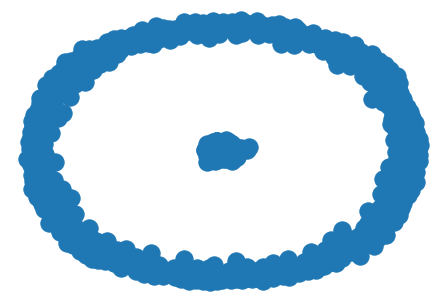

In [39]:
weighted_network = func.convert_to_weighted(G, named_clusters)
print(weighted_network)
nx.draw(weighted_network)

In [22]:
'''
#Finds positions of nodes
pos = nx.spring_layout(weighted_network)

# plots it
nx.draw(weighted_network, pos, with_labels = True)
labels = nx.get_edge_attributes(G,'weight')

#adds the edges in
nx.draw_networkx_edge_labels(weighted_network, pos, edge_labels=labels)
'''

"\n#Finds positions of nodes\npos = nx.spring_layout(weighted_network)\n\n# plots it\nnx.draw(weighted_network, pos, with_labels = True)\nlabels = nx.get_edge_attributes(G,'weight')\n\n#adds the edges in\nnx.draw_networkx_edge_labels(weighted_network, pos, edge_labels=labels)\n"

In [42]:
mapping = {node : f"w{node}" for node in weighted_network.nodes}
weighted_network_rename = nx.relabel_nodes(weighted_network, mapping)
print(weighted_network_rename.nodes)


['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20', 'w21', 'w22', 'w23', 'w24', 'w25', 'w26', 'w27', 'w28', 'w29', 'w30', 'w31', 'w32', 'w33', 'w34', 'w35', 'w36', 'w37', 'w38', 'w39', 'w40', 'w41', 'w42', 'w43', 'w44', 'w45', 'w46', 'w47', 'w48', 'w49', 'w50', 'w51', 'w52', 'w53', 'w54', 'w55', 'w56', 'w57', 'w58', 'w59', 'w60', 'w61', 'w62', 'w63', 'w64', 'w65', 'w66', 'w67', 'w68', 'w69', 'w70', 'w71', 'w72', 'w73', 'w74', 'w75', 'w76', 'w77', 'w78', 'w79', 'w80', 'w81', 'w82', 'w83', 'w84', 'w85', 'w86', 'w87', 'w88', 'w89', 'w90', 'w91', 'w92', 'w93', 'w94', 'w95', 'w96', 'w97', 'w98', 'w99', 'w100', 'w101', 'w102', 'w103', 'w104', 'w105', 'w106', 'w107', 'w108', 'w109', 'w110', 'w111', 'w112', 'w113', 'w114', 'w115', 'w116', 'w117', 'w118', 'w119', 'w120', 'w121', 'w122', 'w123', 'w124', 'w125', 'w126', 'w127', 'w128', 'w129', 'w130', 'w131', 'w132', 'w133', 'w134', 'w135', 'w136', 'w137', 'w138

In [49]:
# finds cluster that the LPD1 or E3 protein is in
# Very interesting, alot of the proteins are int he same cluster
for key, value in important_nodes.items():
    print(func.find_cluster(value, named_clusters), key)

32 LPD1
32 PDA1
32 PYC2
32 PDB1
123 PTC1
93 BAT2
32 KGD1
190 AIM22
464 PKP1
330 PTC5
32 LAT1


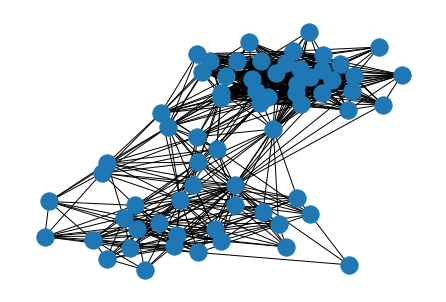

In [50]:
#Make a graph with only nodes in a certain cluster 
#cluster number 32 in this case as it has LPD1
cluster_network = func.cluster_graph(G, named_clusters[32], named_clusters[93])
nx.draw(cluster_network)

In [12]:
b_centrality = func.between_centrality(G, named_clusters[32], named_clusters[93])

In [13]:
# This is comparing cluster 32 and 93

# sorts the dictionary such that highest centrality is first
sorted_betweeness = dict(sorted(b_centrality.items(), key = lambda x: -x[1]))

# for key, val in sorted_betweeness.items():
#     print(f"The node {key} has a betweenness centrality score of {val}")

# gives first 5 maybe or more to BCMB students
prefered_names = func.parser(sorted_betweeness.keys(), False)
print(prefered_names)


{'4932.YGL026C': 'TRP5', '4932.YIL094C': 'LYS12', '4932.YCL009C': 'ILV6', '4932.YNL104C': 'LEU4', '4932.YKL211C': 'TRP3', '4932.YPL262W': 'FUM1', '4932.YOR108W': 'LEU9', '4932.YOR136W': 'IDH2', '4932.YNL037C': 'IDH1', '4932.YMR108W': 'ILV2', '4932.YGL009C': 'LEU1', '4932.YBR221C': 'PDB1', '4932.YBR218C': 'PYC2', '4932.YGL062W': 'PYC1', '4932.YER178W': 'PDA1', '4932.YLR174W': 'IDP2', '4932.YGL202W': 'ARO8', '4932.YKL029C': 'MAE1', '4932.YDL066W': 'IDP1', '4932.YNL009W': 'IDP3', '4932.YOR142W': 'LSC1', '4932.YJR148W': 'BAT2', '4932.YCL030C': 'HIS4', '4932.YDR158W': 'HOM2', '4932.YNL117W': 'MLS1', '4932.YNL071W': 'LAT1', '4932.YER055C': 'HIS1', '4932.YPR060C': 'ARO7', '4932.YNR001C': 'CIT1', '4932.YBR249C': 'ARO4', '4932.YKL085W': 'MDH1', '4932.YPR001W': 'CIT3', '4932.YGL148W': 'ARO2', '4932.YCR005C': 'CIT2', '4932.YBR248C': 'HIS7', '4932.YDR380W': 'ARO10', '4932.YOL126C': 'MDH2', '4932.YAL054C': 'ACS1', '4932.YDL078C': 'MDH3', '4932.YLR304C': 'ACO1', '4932.YIL125W': 'KGD1', '4932.YBL015W

In [51]:
# this here is just within cluster 32

c32 = nx.betweenness_centrality(func.cluster_graph(G, named_clusters[32]))
# print(c32)

In [15]:
# sorts the dictionary such that highest centrality is first
c32_sorted = dict(sorted(c32.items(), key = lambda x: -x[1]))

# for key, val in sorted_betweeness.items():
#     print(f"The node {key} has a betweenness centrality score of {val}")

# gives first 5 maybe or more to BCMB students
c32_sorted = func.parser(c32_sorted.keys(), False)
print(c32_sorted)
print(len(c32_sorted))

{'4932.YCR005C': 'CIT2', '4932.YNR001C': 'CIT1', '4932.YPR001W': 'CIT3', '4932.YKL085W': 'MDH1', '4932.YLR304C': 'ACO1', '4932.YOR136W': 'IDH2', '4932.YOL126C': 'MDH2', '4932.YPL262W': 'FUM1', '4932.YOR142W': 'LSC1', '4932.YIL125W': 'KGD1', '4932.YDL078C': 'MDH3', '4932.YNL117W': 'MLS1', '4932.YER065C': 'ICL1', '4932.YNL037C': 'IDH1', '4932.YKR097W': 'PCK1', '4932.YBR218C': 'PYC2', '4932.YNL071W': 'LAT1', '4932.YGL062W': 'PYC1', '4932.YLR174W': 'IDP2', '4932.YKL029C': 'MAE1', '4932.YER178W': 'PDA1', '4932.YBR221C': 'PDB1', '4932.YDR148C': 'KGD2', '4932.YAL054C': 'ACS1', '4932.YDL066W': 'IDP1', '4932.YBR006W': 'UGA2', '4932.YFL018C': 'LPD1', '4932.YJL200C': 'ACO2', '4932.YBL015W': 'ACH1', '4932.YNL009W': 'IDP3', '4932.YGR193C': 'PDX1', '4932.YOR388C': 'FDH1', '4932.YPR006C': 'ICL2'}
33


Graph with 615 nodes and 5305 edges


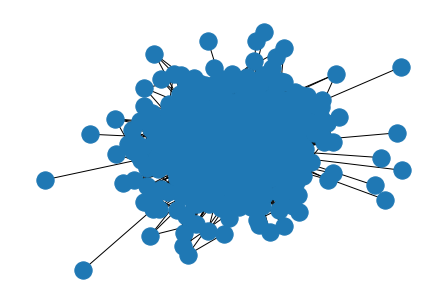

In [44]:
# Iscolated the middle section of the graph as seen in an earlier picture
# Used clsuter 32 as the source as it contains LPD1 

filtered_weight = func.connected_clusters(weighted_network_rename, 'w32')
nx.draw(filtered_weight)
print(filtered_weight)


In [45]:
print(nx.number_connected_components(weighted_network))

436


In [54]:
func.weighted_centrality(filtered_weight, 'w32')
# print(filtered_weight)
# print(named_clusters[32])